In [200]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# Revised (New) Box Model for Li and its Isotopes

## Add a New Flux Term from Weathering

Now the evolution of Li reservoir is:
\begin{equation}
\frac{dM}{dt} = F_r + F_{HT} - F_a - F_{LT},
\end{equation}
where the new term $F_r$ denotes river flux due to weathering. We'll take $F_r$ as constants of experimental values of 10%, 20%, 50% of its modern value ($F_{r,0} = 1e10$ mol/y).

Additionally, the fluxes caused by clay formation ($F_a$) and oceanic alteration ($F_{LT}$) are taken to be dependent on Li concentration in the ocean (e.g., the same formulation from Rugenstein et al. (2019)):
\begin{equation}
F_a = F_{a,0} \frac{C_{Li}}{C_{Li,0}} = F_{a,0} \frac{C_{Li} V_{ocean}}{C_{Li,0}V_{ocean}} = F_{a,0} \frac{M}{M_0},
\end{equation}
where $C_{Li}$ is Li concentration in the ocean, and the subscript "0" indicates initial value (modern value in this study). Note that the above derivation assumes a constant ocean volume.

Similarly, 
\begin{equation}
F_{LT} = F_{LT,0} \frac{C_{Li}}{C_{Li,0}} = F_{LT,0} \frac{M}{M_0}.
\end{equation}

All these modifications considered, the new governing equation for Li reservoir $M$ is:

\begin{equation}
\frac{dM}{dt} = F_r + F_{HT} - F_{a,0} \frac{M}{M_0} - F_{LT,0} \frac{M}{M_0} = F_r + F_{HT} - M(\frac{F_{a,0}}{M_0} + \frac{F_{LT,0}}{M_0}).
\end{equation}

Noticing the constants in the above equation, we let $a = F_r + F_{HT}$ and $b = (F_{a,0} + F_{LT,0})/M_0$ to make the above equation cleaner:

\begin{equation}
\frac{dM}{dt} = a - bM.
\end{equation}

With an initial condition of $M(t) = M_0$ at $t = 0$, the above equation admits the following solution:
\begin{equation}
M(t) = \frac{a}{b} - (\frac{a}{b} - M_0)e^{-bt}.
\end{equation}
This shows the Li reservoir size exponentially decays.

## Add Correction Factors for the Isotope Evolution Equation

After reading Brass (1976) and Rugenstein et al. (2019), the **exact** equation for Li isotope **ratio** ($R = ^7Li/^6Li$) evolution should be (Tian has the note of the derivation):

\begin{equation}
\frac{dR}{dt} = \frac{1}{M}\left[F_r (R_r - R) \frac{1+R}{1+R_r} + F_{HT} (R_{HT} - R) \frac{1+R}{1+R_{HT}} \right] - \frac{1}{M}\left[F_{LT} \varepsilon_{LT} \frac{1+R}{1 + \varepsilon_{LT} + R} +  F_a \varepsilon_a \frac{1+R}{1 + \varepsilon_a + R}\right].
\end{equation}

Substituting equation (2) and (3), we get:
\begin{equation}
\frac{dR}{dt} = \frac{1}{M}\left[F_r (R_r - R) \frac{1+R}{1+R_r} + F_{HT} (R_{HT} - R) \frac{1+R}{1+R_{HT}} \right] - \frac{1}{M_0}\left[F_{LT,0} \varepsilon_{LT} \frac{1+R}{1 + \varepsilon_{LT} + R} +  F_{a,0} \varepsilon_a \frac{1+R}{1 + \varepsilon_a + R}\right].
\end{equation}

Taking out the common factor $1+R$:

\begin{equation}
\frac{dR}{dt} = \frac{1+R}{M}\left[F_r \frac{R_r - R}{1+R_r} + F_{HT} \frac{R_{HT} - R}{1+R_{HT}} \right] - \frac{1+R}{M_0}\left[\frac{F_{LT,0} \varepsilon_{LT}}{1 + \varepsilon_{LT} + R} + \frac{F_{a,0} \varepsilon_a}{1 + \varepsilon_a + R}\right].
\end{equation}

Note that $\Delta_i = \delta_i - \delta = 1000\frac{R_i - R}{R_{std}}$, so we have $R_i - R = \frac{\Delta_i R_{std}}{1000} = \varepsilon_i$. $\varepsilon_i$ therefore depends on fractionation $\Delta_i$ that are taken to be different constants in this study.

We already know the solution for $M(t)$ from equation **(6)**, so only equation **(9)** is left to be solved.


## Governing Equations

\begin{equation}
M(t) = \frac{a}{b} - (\frac{a}{b} - M_0)e^{-bt}.
\end{equation}

\begin{equation}
\frac{dR}{dt} = \frac{1+R}{M}\left[F_r \frac{R_r - R}{1+R_r} + F_{HT} \frac{R_{HT} - R}{1+R_{HT}} \right] - \frac{1+R}{M_0}\left[\frac{F_{LT,0} \varepsilon_{LT}}{1 + \varepsilon_{LT} + R} + \frac{F_{a,0} \varepsilon_a}{1 + \varepsilon_a + R}\right].
\end{equation}

## Below is the Python solver

In [201]:
import numpy as np
import scipy.integrate
import scipy.optimize as opt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt

# activating the command below will cause matplotlib to use 'TEX' to interpret every text
#, but choices of font styles in TEX are limited, so avoid using 'TEX' but rather us
# matploblib's own font/styles, etc.
# plt.rc('text', usetex=True)    
# plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{textcomp}')

%matplotlib inline 
# options: 'notebook' or 'inline'


# default parameter values

F_ht_0 = 1.3e10
F_a_0  = 1.1e10
F_lt_0 = 1.2e10

F_r_modern = 1e10
fraction   = 0.0

F_r_0 = fraction*F_r_modern   # river flux, modern value is 1e10 mol/yr
M0    = 3.575e16
R_std = 1/0.082757 # used for conversion between ratio values and delta values
                   # from James and Palmer (Chemical Geology)

delta_r_d  = 0.023
delta_ht_d = 0.0083
Delta_lt_d = -0.018 # Note this is delta_lt - delta_seawater 
Delta_a_d  = -0.02  # Note this is delta_a - delta_seawater 

### Plot for M(t)

In [202]:
a          = F_r_0 + F_ht_0
b          = (F_a_0 + F_lt_0)/M0
c          = a/b
max_time   = 10.0   # in Ma

time_span  = (0, max_time)   # in Ma
time_step  = np.linspace(0, max_time, num=2000, endpoint=True)  # time for the solution points
M_values   = c - (c - M0) *np.exp(-b*time_step*1e6)

In [203]:
print(c)

2.0206521739130436e+16


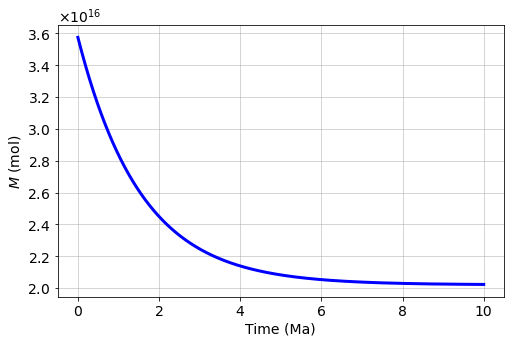

In [204]:
FONT_SIZE = 14
lw        = 3

f = plt.figure(figsize=(8,5))   # results for a default fixed Delta_m = 0.02, plotted for sanity check

# formatter for yaxis tick labels
fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
plt.plot(time_step, M_values, color='b', linewidth=lw)
plt.xlabel('Time (Ma)', size=FONT_SIZE)
plt.ylabel(r'$M$ (mol)', size=FONT_SIZE)
plt.tick_params(labelsize=FONT_SIZE)
plt.gca().yaxis.get_offset_text().set_fontsize(FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)
plt.grid(which='major', alpha=0.65)

#f.savefig('default-reservoir-new.png', dpi = 300)

### Solve for R(t)

In [205]:
delta0      = 0.031   # initial delta of Li
R_0         = (delta0+1)*R_std  # converted to initial ratio
R_r_d       = (delta_r_d+1)*R_std  # river
R_ht_d      = (delta_ht_d+1)*R_std  # hydrothermal input

ep_a_d      = Delta_a_d*R_std  # epsilon for clay formation
ep_lt_d     = Delta_lt_d*R_std  # epsilon for oceanic alteration

In [206]:
# Numerical ODE of Equation (9)

def gov_eq(t, y, F_r=F_r_0, F_ht=F_ht_0, F_a=F_a_0, F_lt=F_lt_0, R_r=R_r_d, R_ht=R_ht_d, ep_lt=ep_lt_d, ep_a=ep_a_d):
    
    a     = F_r + F_ht
    b     = (F_a + F_lt)/M0
    c     = a/b
    M     = c - (c - M0) *np.exp(-b*t) # note here unit of t is yr
    dRdt  = ((1+y)/M)*(F_r*(R_r-y)/(1+R_r) + F_ht*(R_ht-y)/(1+R_ht)) - ((1+y)/M0)*(F_lt*ep_lt/(1+ep_lt+y) + F_a*ep_a/(1+ep_a+y))
    
    return dRdt

In [207]:
# Simplified governing equation by making (1+R)/(1+R_i) = 1

# def gov_eq(t, y, F_r=F_r_0, F_h=F_h_0, F_m=F_m_0, F_a=F_a_0, R_r=R_r_d, R_h=R_h_d, ep_a=ep_a_d, ep_m=ep_m_d):
    
#     a     = F_r + F_h
#     b     = (F_m + F_a)/M0
#     c     = a/b
#     M     = c - (c - M0) *np.exp(-b*t) # note here unit of t is yr
#     dRdt  = ((1+0)/M)*(F_r*(R_r-y) + F_h*(R_h-y)) - ((1+0)/M0)*(F_a*ep_a + F_m*ep_m)
    
#     return dRdt

In [208]:
y0         = [R_0]  # Initial Condition
time_span  = (0, max_time*1e6)   # Convert from Ma to yr
time_step  = np.linspace(0, time_span[-1], num=2000, endpoint=True)  # time for the solution points

In [209]:
time_span[-1]

10000000.0

In [210]:
sol = scipy.integrate.solve_ivp(gov_eq, time_span, y0, method='Radau', t_eval=time_step, rtol=1e-5, atol=1e-8)

In [211]:
deltaLi = (sol.y[0]/R_std - 1)   # convert from isotope ratios to the delta values

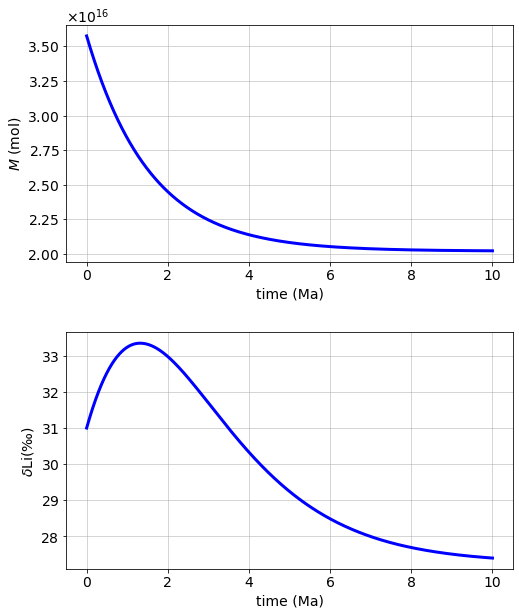

In [212]:
FONT_SIZE = 14
lw        = 3

f = plt.figure(figsize=(8,10))   # results for a default fixed Delta_m = 0.02, plotted for sanity check

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
plt.subplot(2,1,1)
plt.plot(time_step/1e6, M_values, color='b', linewidth=lw)
plt.xlabel('time (Ma)', size=FONT_SIZE)
plt.ylabel(r'$M$ (mol)', size=FONT_SIZE)
plt.tick_params(labelsize=FONT_SIZE)
plt.gca().yaxis.get_offset_text().set_fontsize(FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)
plt.grid(which='major', alpha=0.65)

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
plt.subplot(2,1,2)
plt.plot(sol.t/1e6, deltaLi*1e3, color='b', linewidth=lw)
plt.xlabel('time (Ma)', size=FONT_SIZE)
plt.ylabel(r'$\delta$Li' + '(\u2030)', size=FONT_SIZE)
plt.gca().yaxis.get_offset_text().set_fontsize(FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)
plt.tick_params(labelsize=FONT_SIZE)
plt.grid(which='major', alpha=0.65)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
# f.savefig('default-new.png', dpi = 300)

### Now vary $\Delta_m$ or $\varepsilon_m$ from their default values

In [213]:
da_range         = np.linspace(-0.02, 0, num=500, endpoint=True)  # corresponds to delta_ from 0 to 0.011
ep_a_range       = da_range*R_std   # convert to the epsilon values that are actually used in the governing equation
t_grid, m_grid   = np.meshgrid(time_step, da_range)
delta_mat        = np.empty(t_grid.shape)

for i, epa in enumerate(ep_a_range):
    p_list       = (F_r_0, F_ht_0, F_a_0, F_lt_0, R_r_d, R_ht_d, ep_lt_d, epa)
    sol          = scipy.integrate.solve_ivp(gov_eq, time_span, y0, method='Radau', args=p_list, t_eval=time_step, rtol=1e-5, atol=1e-8)
    delta_mat[i] = (sol.y[0]/R_std - 1)     # convert ratio to delta value

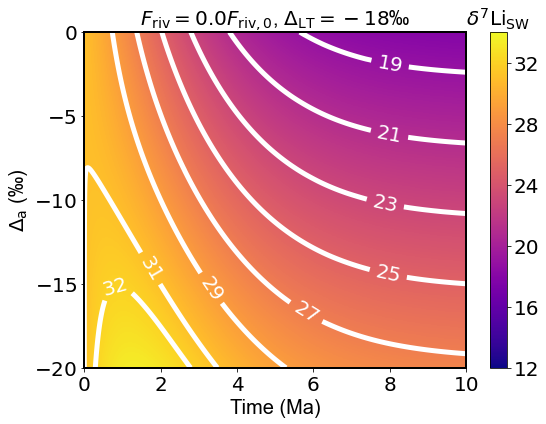

In [215]:
FONT_SIZE = 20
lw        = 5
axlw      = 2
afont = {'fontname':'Arial'}

fig     = plt.figure(figsize=(8,6))
fig.set_tight_layout(True)

colorscalemin = 12
colorscalemax = 34

mesh1   = plt.pcolormesh(t_grid/1e6, m_grid*1e3, delta_mat*1e3, cmap='plasma', vmin = colorscalemin, vmax = colorscalemax, shading='auto')
plt.xlim(0,time_span[-1]/1e6)
plt.ylim(da_range[0]*1e3, 0)
plt.yticks(np.arange(-20, 1, 5))

ax  = plt.gca()
for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(axlw)

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
plt.title(r'$F_{{\rm riv}} = {0:2.1f} F_{{\rm riv,0}}$, $\Delta_{{\rm LT}} = {1:2.0f}$'.format(fraction, 1000*Delta_lt_d)+'\u2030', size=FONT_SIZE, **afont)
plt.xlabel('Time (Ma)', fontsize=FONT_SIZE, fontname='Arial')
plt.ylabel(r'$\Delta_{\rm a}$' + ' (\u2030)', fontsize=FONT_SIZE, **afont)
plt.tick_params(labelsize=FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)

cbar = plt.colorbar(ticks=[12, 16, 20, 24, 28, 32])
cbar.ax.tick_params(labelsize=FONT_SIZE)
cbar.ax.set_title(r'$\delta^7 {\rm Li}_{\rm SW}$', rotation='horizontal', fontsize=FONT_SIZE, **afont)

# clevel  = np.array([15, 17, 19, 21, 23, 25, 27, 29]) # A
# lb_pos  = [(9.0, -1), (8.0, -5), (8.0, -9), (8.0, -12), (8.0, -17), (3.0, -14), (2.0, -14.5), (1.5, -17)] # A

# clevel  = np.array([19, 21, 23, 25, 27, 29, 31.01]) # B
# lb_pos  = [(8.0, -4), (8.0, -8), (8.0, -12), (8.0, -16), (3.0, -15), (1.8, -14), (1.0, -15)] # B

# clevel  = np.array([21, 23, 25, 27, 29, 31.01, 32]) # C
# lb_pos  = [(8.0, -3), (8.0, -6), (8.0, -10), (8.0, -14), (5.0, -17), (2.0, -16), (1.0, -16)] # C

# clevel  = np.array([15, 17, 19, 21, 23, 25, 27, 29]) # D
# lb_pos  = [(8.0, -3), (8.0, -6.5), (8.0, -11), (8.0, -15), (5.0, -17), (3.0, -14), (2.0, -15), (1.5, -17)] # D

# clevel  = np.array([17, 19, 21, 23, 25, 27, 29, 31.01]) # E
# lb_pos  = [(8.0, -2), (8.0, -5.5), (8.0, -9), (8.0, -13), (8.0, -17), (3.0, -13), (2.0, -15), (1.0, -15)] # E

# clevel  = np.array([20, 21, 23, 25, 27, 29, 31.01, 32]) # F
# lb_pos  = [(8.0, -1), (8.0, -4), (8.0, -8), (8.0, -12), (8.0, -16), (3.8, -15), (2.0, -16), (1.0, -16)] # F

# clevel  = np.array([13, 15, 17, 19, 21, 23, 25, 27, 29]) # G
# lb_pos  = [(9.0, -1), (8.0, -5), (8.0, -9), (8.0, -12), (8.0, -17), (3.0, -12.5), (3.0, -16.5), (2.1, -17.5), (1.0, -13)] # G

# clevel  = np.array([17, 19, 21, 23, 25, 27, 29, 31.01]) # H
# lb_pos  = [(8.0, -3.5), (8.0, -7), (8.0, -11), (8.0, -15), (5.0, -17), (2.8, -14), (1.8, -13), (1.0, -15)] # H

clevel  = np.array([19, 21, 23, 25, 27, 29, 31.01, 32]) # I
lb_pos  = [(8.0, -2), (8.0, -6), (8.0, -9), (8.0, -14), (6.0, -16), (3.5, -15), (1.8, -14), (0.8, -15)] # I

cs      = plt.contour(t_grid/1e6, m_grid*1e3, delta_mat*1e3, levels=clevel, colors='w', linewidths=lw)
labels  = plt.clabel(cs, inline=1, fontsize=FONT_SIZE, colors='w', fmt='%2.0f', manual=lb_pos)
# fig.savefig('delta_Li_map-new-g.png', dpi = 300)

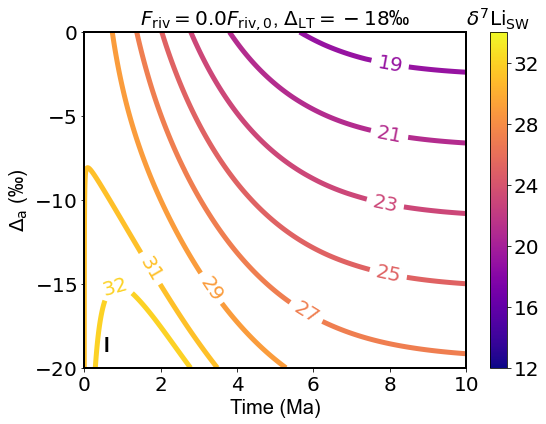

In [216]:
fig     = plt.figure(figsize=(8,6))
fig.set_tight_layout(True)

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.

colorscalemin = 12
colorscalemax = 34
norm          = mpl.colors.Normalize(vmin=colorscalemin, vmax=colorscalemax)

# choose a colormap
c_m       = mpl.cm.plasma  # plasma, inferno, or copper

# create a ScalarMappable and initialize a data structure
s_m       = mpl.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

plt.xlim(0,time_span[-1]/1e6)
plt.ylim(da_range[0]*1e3, 0)
plt.yticks(np.arange(-20, 1, 5))

ax  = plt.gca()
for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(axlw)

fmt = ticker.ScalarFormatter(useMathText=True)
fmt.set_scientific(True)
fmt.set_powerlimits((-2, 2))
plt.title(r'$F_{{\rm riv}} = {0:2.1f} F_{{\rm riv,0}}$, $\Delta_{{\rm LT}} = {1:2.0f}$'.format(fraction, 1000*Delta_lt_d)+'\u2030', size=FONT_SIZE, **afont)
plt.xlabel('Time (Ma)', fontsize=FONT_SIZE, **afont)
plt.ylabel(r'$\Delta_{\rm a}$'+' (\u2030)', fontsize=FONT_SIZE, **afont)
plt.tick_params(labelsize=FONT_SIZE)
plt.gca().yaxis.set_major_formatter(fmt)

cbar = plt.colorbar(mappable=s_m, ticks=[12, 16, 20, 24, 28, 32])
cbar.ax.tick_params(labelsize=FONT_SIZE)
cbar.ax.set_title(r'$\delta^7 {\rm Li}_{\rm SW}$', rotation='horizontal', fontsize=FONT_SIZE, **afont)

# clevel  = np.array([15, 17, 19, 21, 23, 25, 27, 29]) # A
# lb_pos  = [(9.0, -1), (8.0, -5), (8.0, -9), (8.0, -12), (8.0, -17), (3.0, -14), (2.0, -14.5), (1.5, -17)] # A

# clevel  = np.array([19, 21, 23, 25, 27, 29, 31.01]) # B
# lb_pos  = [(8.0, -4), (8.0, -8), (8.0, -12), (8.0, -16), (3.0, -15), (1.8, -14), (1.0, -15)] # B

# clevel  = np.array([21, 23, 25, 27, 29, 31.01, 32]) # C
# lb_pos  = [(8.0, -3), (8.0, -6), (8.0, -10), (8.0, -14), (5.0, -17), (2.0, -16), (1.0, -16)] # C

# clevel  = np.array([15, 17, 19, 21, 23, 25, 27, 29]) # D
# lb_pos  = [(8.0, -3), (8.0, -6.5), (8.0, -11), (8.0, -15), (5.0, -17), (3.0, -14), (2.0, -15), (1.5, -17)] # D

# clevel  = np.array([17, 19, 21, 23, 25, 27, 29, 31.01]) # E
# lb_pos  = [(8.0, -2), (8.0, -5.5), (8.0, -9), (8.0, -13), (8.0, -17), (3.0, -13), (2.0, -15), (1.0, -15)] # E

# clevel  = np.array([20, 21, 23, 25, 27, 29, 31.01, 32]) # F
# lb_pos  = [(8.0, -1), (8.0, -4), (8.0, -8), (8.0, -12), (8.0, -16), (3.8, -15), (2.0, -16), (1.0, -16)] # F

# clevel  = np.array([13, 15, 17, 19, 21, 23, 25, 27, 29]) # G
# lb_pos  = [(9.0, -1), (8.0, -5), (8.0, -9), (8.0, -12), (8.0, -17), (3.0, -12.5), (3.0, -16.5), (2.1, -17.5), (1.0, -13)] # G

# clevel  = np.array([17, 19, 21, 23, 25, 27, 29, 31.01]) # H
# lb_pos  = [(8.0, -3.5), (8.0, -7), (8.0, -11), (8.0, -15), (5.0, -17), (2.8, -14), (1.8, -13), (1.0, -15)] # H

clevel  = np.array([19, 21, 23, 25, 27, 29, 31.01, 32]) # I
lb_pos  = [(8.0, -2), (8.0, -6), (8.0, -9), (8.0, -14), (6.0, -16), (3.5, -15), (1.8, -14), (0.8, -15)] # I

cs      = plt.contour(t_grid/1e6, m_grid*1e3, delta_mat*1e3, levels=clevel, linewidths=lw, cmap=c_m, vmin=colorscalemin, vmax=colorscalemax)
labels  = plt.clabel(cs, inline=1, fontsize=FONT_SIZE, fmt='%2.0f', manual=lb_pos)

plt.text(0.05, 0.05, 'I', transform=ax.transAxes, fontsize=FONT_SIZE, weight="bold", **afont)
fig.savefig('Figure-2I.png', dpi = 300)